In [225]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [226]:
import unittest
from textwrap import dedent
import sys

import networkx as nx
import matplotlib.pyplot as plt

from klara.core.cfg import Cfg
from klara.core.tree_rewriter import AstBuilder
from klara.core.use_def_chain import DefUseLinker, link_stmts_to_def

from cascade.frontend.dataflow_analysis.group_dataflow_nodes import GroupDataflowNodes
from cascade.frontend.dataflow_analysis.edge_placement import EdgePlacement
from cascade.frontend.dataflow_analysis.class_list import ClassList
from cascade.frontend.dataflow_analysis.class_list_builder import ClassListBuilder
from cascade.frontend.dataflow_analysis.class_wrapper import ClassWrapper
from cascade.frontend.util import setup_cfg, plot_graph_with_color, plot_dataflow_graph
from cascade.frontend.intermediate_representation import StatementDataflowGraph, DataflowGraph

# Dataflow Example

In [227]:
example = dedent("""\
                    class User: 
                        def checkout(self, discount: Discount, item_1: Item, item_2: Item):
                            bill = self.get_bill()
                            discount = discount.get_discount()
                            price_1 = item_1.price(discount)
                            price_2 = item_2.price(discount)
                            bill = bill + price_1
                            bill = bill + price_2
                            return bill
                    
                    class Item:
                        pass
                 
                    class Discount:
                        pass
                    """)

In [228]:
example = dedent(example)
cfg = setup_cfg(example)
class_list: ClassList = ClassListBuilder.build(cfg)
entity_1: ClassWrapper = class_list.get_class_by_name('User')
dataflow_graph: StatementDataflowGraph = entity_1.methods['checkout']
G = dataflow_graph.graph
grouper: GroupDataflowNodes = GroupDataflowNodes(G)
groups =  grouper.group_nodes()
f1 = plt.figure(1)
edge_placement: EdgePlacement = EdgePlacement(G, groups)
H = edge_placement.create_dataflow_graph()

<Figure size 640x480 with 0 Axes>

## Statement level data-dependency graph

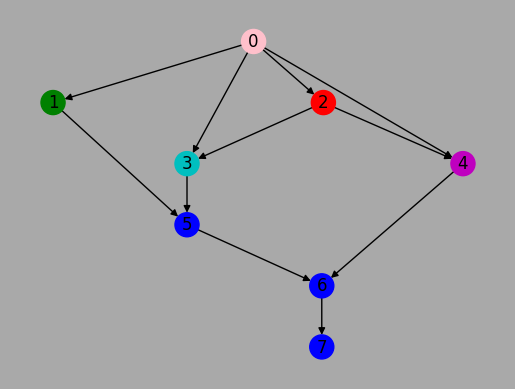

In [229]:
plot_graph_with_color(G)

## Dataflow graph
- Group statements together and remove redundant edges

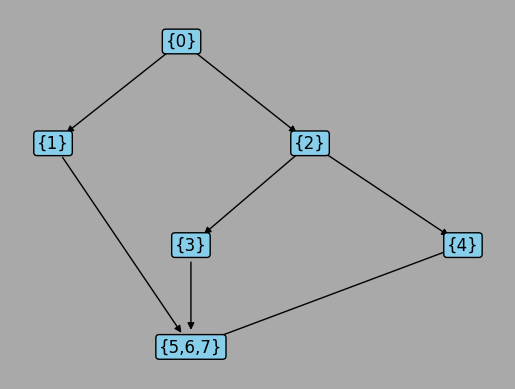

In [230]:
plot_dataflow_graph(H)

## Statement groups

In [231]:
print('Block groups of H')
for block in H.nodes:
    print(f'\n block num {block.block_num}')
    for statement in block.statement_list:
        print(statement.block)

Block groups of H

 block num 0
Function checkout in scope Class "User" in scope Module

 block num 1
Assign: (bill_0,) = Call: self_0.get_bill(())

 block num 2
Assign: (discount_1,) = Call: discount_0.get_discount(())

 block num 3
Assign: (price_1_0,) = Call: item_1_0.price((discount_1,))

 block num 4
Assign: (price_2_0,) = Call: item_2_0.price((discount_1,))

 block num 5
Assign: (bill_1,) = BinOp: bill_0 + price_1_0
Assign: (bill_2,) = BinOp: bill_1 + price_2_0


## Create split functions from statement groups

### Reveal color

In [232]:
for block in H.nodes:
    block.reveal_color()
    print(f'block: {block.block_num} has color: {block.color}')

block: 0 has color: -1
block: 1 has color: 1
block: 2 has color: 2
block: 3 has color: 3
block: 4 has color: 4
block: 5 has color: 0


All nodes are colored, therefore we must resolve which entities represent which colors.

In [233]:
block_level_dataflow_graph = DataflowGraph(H, dataflow_graph.color_type_map, dataflow_graph.method_name)
print(block_level_dataflow_graph.color_type_map)

{2: 'Discount', 3: 'Item', 4: 'Item', 1: 'User'}


### In variables per block.

In [234]:
from textwrap import indent
from cascade.frontend.generator.generate_split_functions import GenerateSplittFunctions
from cascade.frontend.intermediate_representation import Block

compiled_functions, df = GenerateSplittFunctions.generate_split_function_string(block_level_dataflow_graph)

In [235]:
for v in df.nodes.values():
    print(v)

OpNode(id=192, cls='StatelessEntity', method_type=InvokeMethod(method_name='compiled_method_0'))
OpNode(id=193, cls='User', method_type=InvokeMethod(method_name='compiled_method_1'))
OpNode(id=194, cls='Discount', method_type=InvokeMethod(method_name='compiled_method_2'))
OpNode(id=197, cls='StatelessEntity', method_type=InvokeMethod(method_name='compiled_method_5'))
OpNode(id=195, cls='Item', method_type=InvokeMethod(method_name='compiled_method_3'))
OpNode(id=196, cls='Item', method_type=InvokeMethod(method_name='compiled_method_4'))


In [236]:


for node in block_level_dataflow_graph.get_nodes():
    node: Block
    print(f'block {node.block_num} in vars: {node.in_vars}')



block 0 in vars: {'self_0', 'item_2_0', 'discount_0', 'item_1_0'}
block 1 in vars: set()
block 2 in vars: set()
block 3 in vars: {'discount_1'}
block 4 in vars: {'discount_1'}
block 5 in vars: {'price_1_0', 'bill_0', 'price_2_0'}


In [237]:
print(compiled_functions)

def stateless_entity_compiled_method_0(variable_map: dict[str, Any], *, state: StatelessEntity, key_stack: list[str]): 
	self_0 = variable_map['self_0']
	item_2_0 = variable_map['item_2_0']
	discount_0 = variable_map['discount_0']
	item_1_0 = variable_map['item_1_0']
	key_stack.append([self_0.key, discount_0.key]))

def stateless_entity_compiled_method_5(variable_map: dict[str, Any], *, state: StatelessEntity, key_stack: list[str]): 
	key_stack.pop()
	price_1_0 = variable_map['price_1_0']
	bill_0 = variable_map['bill_0']
	price_2_0 = variable_map['price_2_0']
	bill_1 = bill + price_1
	bill_2 = bill + price_2
	return bill

def user_compiled_method_1(variable_map: dict[str, Any], *, state: User, key_stack: list[str]): 
	key_stack.pop()
	bill_0 = state.get_bill(())
	key_stack.append(stateless_entity.key))

def discount_compiled_method_2(variable_map: dict[str, Any], *, state: Discount, key_stack: list[str]): 
	key_stack.pop()
	discount_1 = state.get_discount(())
	key_stack.append([item_1_

## Simple program example

In [238]:
example = """\
                class User: 
                        def buy_item(self, item: Item):
                            item_price = item.item_price() # SSA
                            self.balance = self.balance - item_price
                            return self.balance >= 0

                class Item:
                    pass
                """
example = dedent(example)

In [239]:
example = dedent(example)
cfg = setup_cfg(example)
class_list: ClassList = ClassListBuilder.build(cfg)
entity_1: ClassWrapper = class_list.get_class_by_name('User')
dataflow_graph: StatementDataflowGraph = entity_1.methods['buy_item']
G = dataflow_graph.graph
grouper: GroupDataflowNodes = GroupDataflowNodes(G)
groups =  grouper.group_nodes()
f1 = plt.figure(1)
edge_placement: EdgePlacement = EdgePlacement(G, groups)
H = edge_placement.create_dataflow_graph()


<Figure size 640x480 with 0 Axes>

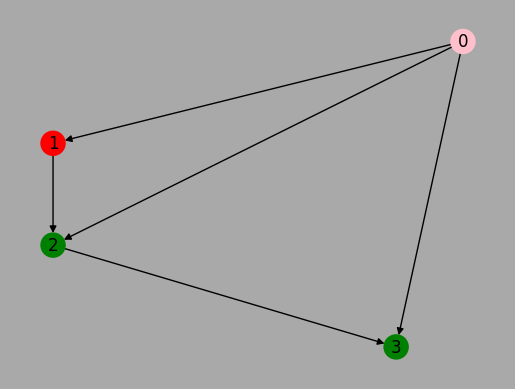

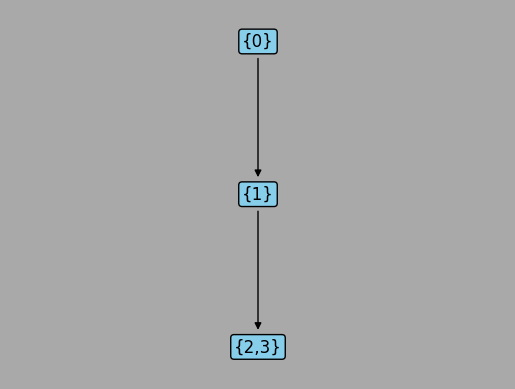

In [240]:
plot_graph_with_color(G)
plot_dataflow_graph(H)

In [241]:
block_level_dataflow_graph = DataflowGraph(H, dataflow_graph.color_type_map, dataflow_graph.method_name)
compiled_functions, df = GenerateSplittFunctions.generate_split_function_string(block_level_dataflow_graph)
print(compiled_functions)

def stateless_entity_compiled_method_0(variable_map: dict[str, Any], *, state: StatelessEntity, key_stack: list[str]): 
	item_0 = variable_map['item_0']
	self_0 = variable_map['self_0']
	key_stack.append(item_0.key))

def item_compiled_method_1(variable_map: dict[str, Any], *, state: Item, key_stack: list[str]): 
	key_stack.pop()
	item_price_0 = state.item_price(())
	key_stack.append(self_0.key))

def user_compiled_method_2(variable_map: dict[str, Any], *, state: User, key_stack: list[str]): 
	key_stack.pop()
	item_price_0 = variable_map['item_price_0']
	self_0.balance_0 = state.balance - item_price
	return state.balance >= 0




## Generated dataflow

### Nodes

In [242]:
for v in df.nodes.values():
    print(v)

OpNode(id=198, cls='StatelessEntity', method_type=InvokeMethod(method_name='compiled_method_0'))
OpNode(id=199, cls='Item', method_type=InvokeMethod(method_name='compiled_method_1'))
OpNode(id=200, cls='User', method_type=InvokeMethod(method_name='compiled_method_2'))


### Edges

In [243]:
print(df.adjacency_list)

{198: [199], 199: [200], 200: []}


In [244]:
def user_compiled_method_0(variable_map: dict[str, Any], *, state: StatelessEntity, key_stack: list[str]): 
	item_0 = variable_map['item_0']
	self_0 = variable_map['self_0'] # <-
	key_stack.append(item_0_key)

def item_compiled_method_1(variable_map: dict[str, Any], *, state: Item, key_stack: list[str]): 
	key_stack.pop()
	item_price_0 = state.item_price()
	return item_price_0

def user_compiled_method_2(variable_map: dict[str, Any], *, state: User, key_stack: list[str]): 
	key_stack.pop()
	item_price_0 = variable_map['item_price_0']
	self_0.balance_0 = state.balance - item_price_0
	return state.balance >= 0


NameError: name 'Any' is not defined

In [ ]:
item_1 = item_compiled_method_1()
item_2 = item_compiled_method_1()